# Neural Network from scratch 
### Machine learning assignment 2:
---
Mitchell Kijurina

### Extract the dataset from the zip 

Zip file downloaded from Kaggle [here](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)


In [1]:
import zipfile
import os
import matplotlib.pyplot as plt


# Define the directory where the extracted files will be stored

extracted_dir = './data/mnist_data'

# Create the directory if it doesn't exist

if not os.path.exists(extracted_dir):
    os.makedirs(extracted_dir)

# Extract the ZIP file
with zipfile.ZipFile('./data/archive.zip', 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


# List the extracted files
extracted_files = os.listdir(extracted_dir)
print(extracted_files)


['t10k-images-idx3-ubyte', 'train-labels.idx1-ubyte', '.DS_Store', 'train-images.idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels-idx1-ubyte']


## Data loading and pre-processing 
---
Load the data in using numpy, put data into binary arrays, than pre-process

Note regarding fromBuffer:
Used for typecasting and slicing

In [2]:
import numpy as np

def load_mnist_images(filename):
    """Load MNIST images from a given file"""
    with open(filename, "rb") as f:
        # Read header information
        magic_number = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        num_images = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        num_rows = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        num_cols = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        
        # Read image data
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape((num_images, num_rows * num_cols))
        
    return images / 255.0  # Normalize to [0, 1]

def load_mnist_labels(filename):
    """Load MNIST labels from a given file"""
    with open(filename, "rb") as f:
        # Read header information
        magic_number = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        num_labels = np.frombuffer(f.read(4), dtype=np.dtype(">i4"))[0]
        
        # Read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return labels

# Load training and test data
train_images = load_mnist_images(os.path.join(extracted_dir, 'train-images.idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(extracted_dir, 'train-labels.idx1-ubyte'))
test_images = load_mnist_images(os.path.join(extracted_dir, 't10k-images.idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(extracted_dir, 't10k-labels.idx1-ubyte'))

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 784), (60000,), (10000, 784), (10000,))

## Images

Training images: 60,000 samples, each with 784 features (28x28 pixels flattened)
Training labels: 60,000 labels corresponding to the training images
Test images: 10,000 samples, each with 784 features
Test labels: 10,000 labels corresponding to the test images

## Implimentation of neural network 
The implimentation of a feedforward neural network with one hidden layer 

    Input Layer: 784 units (corresponding to the 28x28 pixel values)
    Hidden Layer: 128 units (arbitrary)
    Output Layer: 10 units (corresponding to the 10 digit classes)

We'll use the ReLU (Rectified Linear Unit) activation function for the hidden layer and the softmax function for the output layer.

In [3]:
# Initialize weights and biases
np.random.seed(0)  # For reproducibility

# Parameters for the hidden layer
input_size = 784  # Number of input neurons
hidden_size = 128  # Number of hidden neurons

W1 = np.random.randn(input_size, hidden_size) * 0.01  # Weights for the hidden layer
b1 = np.zeros((1, hidden_size))  # Biases for the hidden layer

# Parameters for the output layer
output_size = 10  # Number of output neurons (10 classes) --> Corresponds to the 10 digits

W2 = np.random.randn(hidden_size, output_size) * 0.01  # Weights for the output layer
b2 = np.zeros((1, output_size))  # Biases for the output layer

W1.shape, b1.shape, W2.shape, b2.shape


((784, 128), (1, 128), (128, 10), (1, 10))

## Impliment activation functions

ReLu 

Softmax

In [4]:
def relu(Z):
    """ReLU activation function"""
    return np.maximum(0, Z)

def softmax(Z):
    """Softmax activation function"""
    exp_Z = np.exp(Z - np.max(Z))  # Numerical stability
    return exp_Z / exp_Z.sum(axis=1, keepdims=True)

# Forward Propagation

In forward propagation, we'll perform the following operations:

    Linear Transformation: XW+bXW+b
    Activation Function: ReLU for the hidden layer and Softmax for the output layer

First, let's initialize the weights and biases for the hidden and output layers. We'll use small random values for the weights and zeros for the biases.

In [5]:
# Forward propagation for a single layer
def forward_layer(A_prev, W, b, activation):
    """Forward propagation for a single layer"""
    Z = np.dot(A_prev, W) + b
    if activation == 'relu':
        A = relu(Z)
    elif activation == 'softmax':
        A = softmax(Z)
    return A, Z

# Forward propagation for the entire network
def forward_propagation(X, W1, b1, W2, b2):
    """Forward propagation for the entire network"""
    # Hidden layer
    A1, Z1 = forward_layer(X, W1, b1, 'relu')
    # Output layer
    A2, Z2 = forward_layer(A1, W2, b2, 'softmax')
    return A1, Z1, A2, Z2

# Take a subset of training data
X_subset = train_images[:5]
y_subset = train_labels[:5]

# Perform forward propagation
A1, Z1, A2, Z2 = forward_propagation(X_subset, W1, b1, W2, b2)


Backwards Propagation

In backward propagation, we'll perform the following steps:

    Compute Output Error: Calculate the difference between the predicted output and the actual labels.
    Backpropagate the Error: Calculate the gradients for the weights and biases by propagating the error backward through the network.

In [7]:
# One-hot encode the labels
def one_hot_encode(labels, num_classes):
    """One-hot encode the given labels"""
    encoded = np.zeros((labels.shape[0], num_classes))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded

# Backward propagation for a single layer
def backward_layer(dA, Z, A_prev, W, activation):
    """Backward propagation for a single layer"""
    if activation == 'relu':
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == 'softmax':
        dZ = dA  # Softmax error is directly passed as dZ
    dW = np.dot(A_prev.T, dZ)
    db = np.sum(dZ, axis=0, keepdims=True)
    dA_prev = np.dot(dZ, W.T)
    return dA_prev, dW, db

# Backward propagation for the entire network
def backward_propagation(A1, Z1, A2, Z2, X, y, W2):
    """Backward propagation for the entire network"""
    m = X.shape[0]
    
    # Output layer
    y_encoded = one_hot_encode(y, 10)
    dA2 = A2 - y_encoded
    dA1, dW2, db2 = backward_layer(dA2, Z2, A1, W2, 'softmax')
    
    # Hidden layer
    _, dW1, db1 = backward_layer(dA1, Z1, X, W1, 'relu')
    
    # Normalize gradients by the number of samples
    dW1 /= m
    db1 /= m
    dW2 /= m
    db2 /= m
    
    return dW1, db1, dW2, db2

# Perform backward propagation using the same subset of training data
dW1, db1, dW2, db2 = backward_propagation(A1, Z1, A2, Z2, X_subset, y_subset, W2)




# Training Loop

Now that both forward and backward propagation set up, the next step is to integrate these into a training loop. Inside the loop, we'll perform the following operations:

    Forward Propagation: Compute the network output
    Loss Calculation: Compute the loss function value
    Backward Propagation: Compute gradients
    Update Parameters: Update weights and biases using gradients

We'll use the categorical cross-entropy loss as our loss function and a simple gradient descent algorithm for updating the parameters.

In [8]:
# Categorical Cross-Entropy Loss
def cross_entropy_loss(A, y):
    """Compute the categorical cross-entropy loss"""
    m = y.shape[0]
    y_encoded = one_hot_encode(y, 10)
    log_probs = np.log(A) * y_encoded
    loss = -np.sum(log_probs) / m
    return loss

# Update parameters using Gradient Descent
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """Update parameters using gradient descent"""
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

# Training Loop
def train_neural_network(X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
    """Train the neural network"""
    # Initialize parameters
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    
    # Store loss and accuracy for plotting
    train_losses = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(1, epochs + 1):
        # Shuffle training data for each epoch
        shuffle_indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[shuffle_indices]
        y_train_shuffled = y_train[shuffle_indices]
        
        for i in range(0, len(X_train), batch_size):
            # Mini-batch data
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            
            # Forward propagation
            A1, Z1, A2, Z2 = forward_propagation(X_batch, W1, b1, W2, b2)
            
            # Compute loss
            loss = cross_entropy_loss(A2, y_batch)
            
            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(A1, Z1, A2, Z2, X_batch, y_batch, W2)
            
            # Update parameters
            update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        # Evaluate the model
        _, _, A2_test, _ = forward_propagation(X_test, W1, b1, W2, b2)
        test_predictions = np.argmax(A2_test, axis=1)
        test_accuracy = np.mean(test_predictions == y_test)
        
        # Store metrics
        train_losses.append(loss)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch}/{epochs} - Loss: {loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    return W1, b1, W2, b2, train_losses, test_accuracies

# Hyperparameters
epochs = 10
batch_size = 128
learning_rate = 0.1

# Train the neural network
W1_trained, b1_trained, W2_trained, b2_trained, train_losses, test_accuracies = train_neural_network(
    train_images, train_labels, test_images, test_labels, epochs, batch_size, learning_rate)


Epoch 1/10 - Loss: 0.3602 - Test Accuracy: 0.9071
Epoch 2/10 - Loss: 0.2687 - Test Accuracy: 0.9225
Epoch 3/10 - Loss: 0.2109 - Test Accuracy: 0.9325
Epoch 4/10 - Loss: 0.1647 - Test Accuracy: 0.9404
Epoch 5/10 - Loss: 0.1468 - Test Accuracy: 0.9487
Epoch 6/10 - Loss: 0.3448 - Test Accuracy: 0.9557
Epoch 7/10 - Loss: 0.0841 - Test Accuracy: 0.9598
Epoch 8/10 - Loss: 0.1906 - Test Accuracy: 0.9615
Epoch 9/10 - Loss: 0.1693 - Test Accuracy: 0.9638
Epoch 10/10 - Loss: 0.0924 - Test Accuracy: 0.9665


# Evaluation 

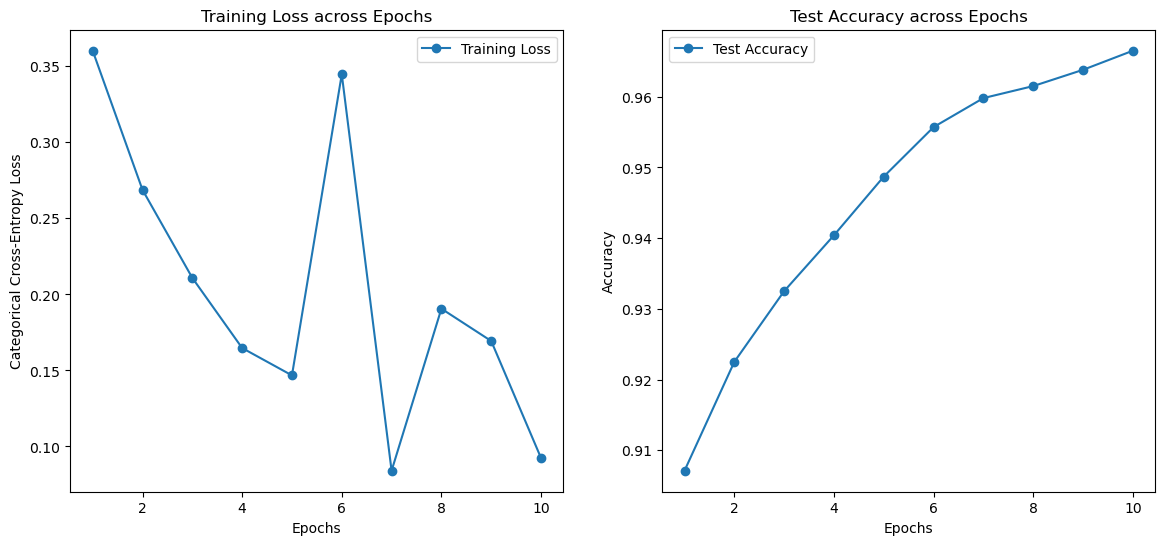

In [8]:
import matplotlib.pyplot as plt

# Plot training loss and test accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training loss
ax1.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
ax1.set_title('Training Loss across Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Categorical Cross-Entropy Loss')
ax1.legend()

# Plot test accuracy
ax2.plot(range(1, epochs + 1), test_accuracies, marker='o', label='Test Accuracy')
ax2.set_title('Test Accuracy across Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


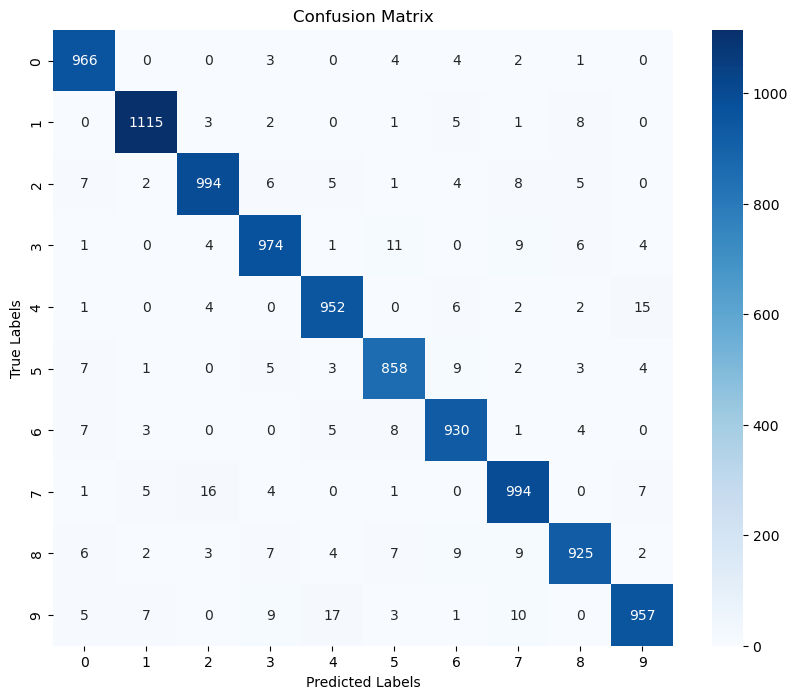

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Generate predictions on the test set
_, _, A2_test, _ = forward_propagation(test_images, W1_trained, b1_trained, W2_trained, b2_trained)
test_predictions = np.argmax(A2_test, axis=1)


# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)


import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
